In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.sparse import csc_matrix
import os
import math

Counts and UMIs are used here interchangeably. List all necessary files for creating anndata objects for each sample:

In [3]:
raw_files = sorted([i for i in os.listdir() if "gz" in i])

There are three files per sample: ``barcodes.tsv``, ``genes.tsv`` and ``matrix.mtx``. We sorted our ``raw_files`` list as we want these files to be grouped together according to the corresponding sample, which will simplify the process of creating the **anndata** objects. We will group all three files per sample and store them in a new list:

In [4]:
raw_adatas = [raw_files[i:i+3] for i in range(0, len(raw_files), 3)]

Now we will write a wraper function to read each file per sample and create an **anndata** object for every sample, and we will also add columns that will describe our **samples** and **observarions**, whcih will come in handy once we merge our datasets:

In [5]:
def read_adata(adata_list):
    # The thrid file in the sublist is the mtx file
    adata = sc.read_mtx(adata_list[2]).T
    # The first the barcodes.tsv file
    barcodes_file = pd.read_csv(adata_list[0], header = None).iloc[:,0]
    # The third the genes.tsv file
    genes_file = pd.read_csv(adata_list[1], sep = "\t", header = None)
    
    # We will use this to get sample, patient and dx information (dx is diagnosis)
    _, patient, dx, _, _= adata_list[0].split("_")

    # Variables
    adata.var_names = genes_file.iloc[:,1]
    adata.var["gene_id"] = genes_file.iloc[:,0].values
    adata.var["mt"] = adata.var_names.str.startswith('MT-') # Add boolean values
    adata.var["ribo"] = adata.var_names.str.startswith("RPS", "RPL") # Add boolean values
    adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]") # Add boolean values

    # Observations
    adata.obs_names = barcodes_file
    adata.obs["sample"] = f"{patient}_{dx}"
    adata.obs["patient"] = patient
    adata.obs["dx"] = dx
    return adata

We also defined genes (**mitochondrial**, **ribosomal** and **hemoglobin**) that we will use as covariates for estimating quality metrics, which we will explain later in the **quality control section**. Since the adatas are quite large, and there is no enough memory, we will subset our samples to the first ten. Let's read our data and store each ``anndata`` from each sample inside a list:

In [6]:
adatas = [read_adata(i) for i in raw_adatas[0:2]]

In [7]:
adatas

[AnnData object with n_obs × n_vars = 6794880 × 33538
     obs: 'sample', 'patient', 'dx'
     var: 'gene_id', 'mt', 'ribo', 'hb',
 AnnData object with n_obs × n_vars = 6794880 × 33538
     obs: 'sample', 'patient', 'dx'
     var: 'gene_id', 'mt', 'ribo', 'hb']

The object above is a view object.

Add the bolean values to the var data, so we can use mt-RNA for the removal of ambient RNA

Looks like DoubletFinder outpreforms other methods for doublet removal

## Quality Control

### Empty droplets
Before filtering low quality cells and removing doublets, is necessary to do an estimation of droplets that do not contain cells. Tipically empty droplets contain counts, since we also need to take into account the ambient RNA which is usually present in droplets and is a form of contamination. Therefore, we need to calculate which barcodes don't contain cells and whose counts are the result of RNA contamination. We will use the ``DropletUtils`` package from bioconductor for this purpose.
Now is a good idea to calculate the quality metrics, as they will give us the total counts per cell, as well as the percentage of mitochondrial gene counts, which we will later use to filter low quality cells:

In [8]:
# First calculate some metrics that will give us an estimation of the UMI counts per barcode
for adata in adatas:
    sc.pp.calculate_qc_metrics(adata, inplace=True, qc_vars=["mt", "ribo", "hb"], percent_top=[20], log1p=True) # log1p=log(1+x)

In [9]:
adatas

[AnnData object with n_obs × n_vars = 6794880 × 33538
     obs: 'sample', 'patient', 'dx', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
     var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
 AnnData object with n_obs × n_vars = 6794880 × 33538
     obs: 'sample', 'patient', 'dx', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
     var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells

Let's visualize the total UMI counts for each barcode against the barcodes ranked from highest to lowest UMI counts. This will give us an idea of the quality of our dataset and the presence of background counts (likely empty droplets).

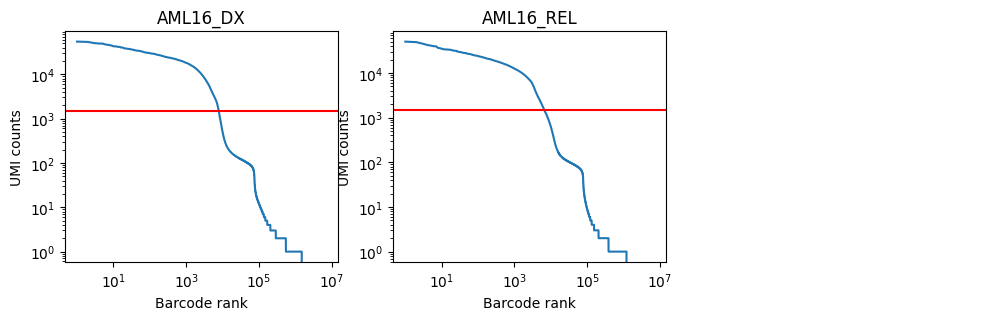

In [10]:
# Set figure and number of axes
n_rows = math.ceil(len(adatas)/3) # This will always round up (Python round() round to the nearest even number)
fig, axs = plt.subplots(n_rows, 3, figsize=(12, 3))

for ax in axs:
    ax.axis("off")

# Conver array to one dimension to easyly iterate
axs = axs.flat

for ax,adata in zip(axs, adatas):
    # Prepare ranks and total counts
    total_counts = adata.obs["total_counts"].sort_values(ascending=False)
    ranks = range(1, len(total_counts) + 1)

    # Plot ranks vs total_counts
    ax.loglog(ranks, total_counts) # This is in log10 scale, it gives almost the same information as log(1+x) or log(x), you can change the base
    ax.axhline(1500, 0,1, color='red')
    ax.set_xlabel("Barcode rank")
    ax.set_ylabel("UMI counts")
    ax.set_title(adata.obs["sample"].iloc[0])
    ax.axis("on") # Set axis back on

We can see **knee plots** characteristic of high quality samples, with both a 'cliff' and a 'knee' (view cell ranger [rank plot](https://www.10xgenomics.com/support/software/cell-ranger/latest/advanced/cr-barcode-rank-plot)). Note that ``DropletUtils`` calls 'knee' what cell ranger calls 'cliff'. The 'cliff' is the sharp transition between well caputerd cells and poor captured cells, background noise (e.g. ambient RNA) or even cell types with very low RNA content (e.g. represented in the small plateau). The 'knee' represents the second inflection point where there are not valid barcodes anymore, no biological variation can be inferred from these barcodes. For more info and a comment on transpossing this plot check [Lior Pachter's blog](https://liorpachter.wordpress.com/tag/knee-plot/).

Now prepare the raw data, which we will input into our R session and the ``EmptyDrops`` function from the ``DropletsUtils`` package, and from which we will obtain the first version of the filtered dataset as output. For this, we will use the original ``genes.tsv``, ``barcodes.tsv`` and ``matrix.mtx`` files from our directory, instead of using the ``adatas`` list. This way we will save a lot of space in memory.

We will proceed with our **R session**. We will take advantage of interoperability between languages so that we can use tools from R and Python, therefore being able to have full access the libraries from both platforms. For this, we are going to install the ``rpy2`` package and use it for our R session. And to be able to load anndata into R, we are going to use the ``anndata2ri`` package. Load the R environment as follows:

In [11]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_403/3659631106.py:9: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Let's initiate *R*, load ``DropletUtils`` amd run ``EmptyDrops``. ``EmptyDrops`` estimates the ambient RNA from the droplests and creates a pool of RNAs, upon which a number of Monte Carlo simulations will be performed, and *p-values* will be computed. The Limited field in the output indicates whether a lower p-value could be obtained by increasing niters. If any non-significant barcodes are TRUE for Limited, we may need to increase the number of iterations. A larger number of iterations will result in a lower p-value for these barcodes, which may allow them to be detected after correcting for multiple testing (from the [Bioconductor tutorial](https://bioconductor.org/books/3.14/OSCA.advanced/droplet-processing.html)).

In [12]:
trial = raw_adatas[0:2]

In [13]:
trial

[['GSM7494257_AML16_DX_raw_barcodes.tsv.gz',
  'GSM7494257_AML16_DX_raw_genes.tsv.gz',
  'GSM7494257_AML16_DX_raw_matrix.mtx.gz'],
 ['GSM7494258_AML16_REL_raw_barcodes.tsv.gz',
  'GSM7494258_AML16_REL_raw_genes.tsv.gz',
  'GSM7494258_AML16_REL_raw_matrix.mtx.gz']]

In [14]:
%%R -i trial -o df_list

suppressMessages(library(Matrix))
suppressMessages(library(DropletUtils))

# Keep output inside a list
df_list = list()

# This will give us the number of samples (we have three files per samples)
n_samples = length(trial)/3

# This will round up same as we did above, to obtain the number of rows for three columns and n_samples
n_rows = ceiling(n_samples/3)

par(mfrow=c(n_rows,3))

for (i in seq(1, length(trial), 3)){
    # Read .mtx file
    feat_mat = readMM(trial[i+2])
    # Read .tsv files
    genes = read.table(trial[i+1], sep = "\t", header = FALSE)
    barcodes = read.table(trial[i], sep = "\t", header = FALSE)
    # Add the appropiate rownames and column names to the sparse matrix
    rownames(feat_mat) = genes[,2]
    colnames(feat_mat) = barcodes[,1]
    print("start")
    # Call emptyDrops
    e.out = emptyDrops(feat_mat, test.ambient=FALSE)
    print(trial[i+2])
    print(summary(e.out$FDR <= 0.001))
    print(table(Sig=e.out$FDR <= 0.001, Limited=e.out$Limited))

    # Plot p-values for cells with equal or below lower number
    #hist(e.out$PValue[e.out$Total <= 100 & e.out$Total > 0], 
    #     main=trial[i+2], # Set title by sample
    #     xlab="P-value", main="", col="grey80")

    # Barcodes that are not significant are not empty (do not show ambient profile)
    e.out = e.out$FDR <= 0.001

    # Append barcdoes to filter to list
    df_list[[length(df_list)+1]] = e.out
}


[1] "start"
[1] "GSM7494257_AML16_DX_raw_matrix.mtx.gz"
   Mode   FALSE    TRUE    NA's 
logical   39278    8288 6747314 
       Limited
Sig     FALSE  TRUE
  FALSE 39278     0
  TRUE      0  8288
[1] "start"
[1] "GSM7494258_AML16_REL_raw_matrix.mtx.gz"
   Mode   FALSE    TRUE    NA's 
logical   26463    6127 6762290 
       Limited
Sig     FALSE  TRUE
  FALSE 26463     0
  TRUE      6  6121


**Looks like most of the barcodes are empty droplests**. The ambient RNA pool is estimated based on barcodes with UMI counts less or equal to the ``lower`` parameter from ``EmptyDrops``, which by default is ``100``. Bear in mind that it doesn't seem like there is an ideal or right ``lower`` value, and it highly depends on things such as the sequencing depth. ``EmptyDrops`` assumes that barcodes with low total UMI counts are empty droplets, a good test for how well the ``lower`` value adjusts for our data is to plot an histogram of the estimated *p-values* (not the Monte Carlo *p-values*), which should be close to uniform. For this we would need to set ``test.ambient=TRUE``, which will return the *p-values* for each cell (this might not be explained correctly, see [Bioconductor](https://bioconductor.org/books/3.18/OSCA.advanced/droplet-processing.html#qc-dropletshttps://bioconductor.org/books/3.18/OSCA.advanced/droplet-processing.html#qc-droplets) and 'Handling overdispersion' from the ``DropletUtils`` manual). This takes an enternity, so we are going to ignore it for now.

The **R session** above will give us a vector for each sample containing boolean values according to a FDR(false discovery rate )-adjusted p-value of 0.001 or less, that is, we call cells at a FDR of 0.1%, meaning that no more than 0.1% of our called barcodes should be empty droplets on average.
Let's get each vector from the outputed dictionary, and transfrom them using ``np.asarray``. This will result in am array with values ``0``, ``1`` and ``-2147483648`` for ``FALSE``, ``TRUE`` and ``NA``, which we will use to filter our anndatas.

In [15]:
vectors = [values for keys, values in df_list.items()]

In [16]:
len(np.asanyarray(vectors[0]) == 1)

6794880

Let's create a functions to filter our anndatas:

In [17]:
def empty_drops(adata, vector):
    to_filt = np.asanyarray(vector) == 1 # We want to keep values that are true
    adata = adata[to_filt]
    return adata

And apply the function to each anndata inside the ``adatas`` object, replacing it:

In [18]:
adatas = [empty_drops(adata, vector) for adata,vector in zip(adatas,vectors)]

In [19]:
adatas

[View of AnnData object with n_obs × n_vars = 8288 × 33538
     obs: 'sample', 'patient', 'dx', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
     var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
 View of AnnData object with n_obs × n_vars = 6127 × 33538
     obs: 'sample', 'patient', 'dx', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
     var: 'gene_id', 'mt', 'ribo', 'hb'

It is necessary to consider that that some variables appear more than once which can lead to errors or unintended behavior for downstream analysis tasks. We execute the proposed function var_names_make_unique() which makes the variable name unique by appending a number string to each duplicate index element: ‘1’, ‘2’, etc (from [the Single Cell Best Practices book](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html).

In [20]:
for adata in adatas:
    adata.var_names_make_unique()

/home/fernando/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/fernando/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### Low quality cells
To remove outliers or low quality cells, we will use [the Median Absotulte Deviation](https://medium.com/@pavanreddy1828/unveiling-the-power-of-median-absolute-deviation-a-guide-to-understanding-data-spread-9a823e174457). The MAD method for assessing dispersion is very robust against outliers, if we compare it with the standard deviation or the mean aboslute deviation. We will set cells as low quality if they differ by *x* number of MADs away from the median. Common tresholds are x=3 to x=5.

We will use these three covariates to filter our dataset:
1. The number of counts per barcode (count depth)
2. The number of genes per barcode
3. The fraction of counts from mitochondrial genes per barcode

We choose these 3 covariates as they are symptoms of cells with broken membranes whose cytoplasmic mRNA has leaked out and therefore only the mRNA in the mitochondria is still present. We will take into account all these covariates.

Since we already calculated the quality metrics abovee, let's do some data exploration by plotting some significant metrics. We will create a function to plot the ``pct_counts_mt``, as there seems to be a problem with subplots with several axes and the scatterplot function from scanpy (the color bar does not display correctly):

In [21]:
def scatter_plot(adata, axe, fig, var1: str, var2: str, colby: str):
    # We sort the mt counts as we want to bring to the front the hightest pc_counts_mt points, colored by hue
    plot = sns.scatterplot(x=var1, y=var2, data=adata.obs.sort_values(colby), ax=axe, hue=colby, palette="viridis", size=0.1, linewidth=0)
    norm = plt.Normalize(adata.obs[colby].min(), adata.obs[colby].max()) # To add color bar
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm) # To add color bar
    sm.set_array([]) # To add color bar
    plot.get_legend().remove() # To add color bar
    colorbar = fig.colorbar(sm, ax=axe) # To add color bar
    return plt, colorbar

And now, let's plot some relevant variables (**Should I plot the log values instead?**):

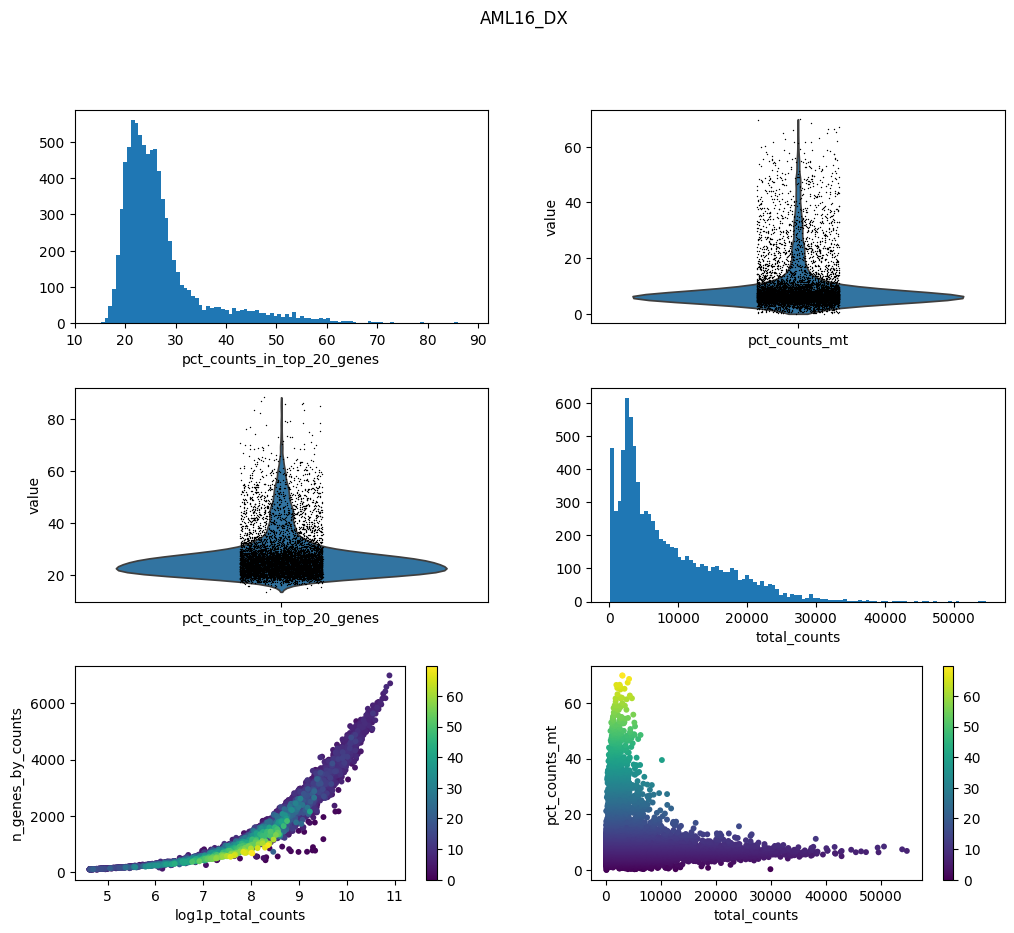

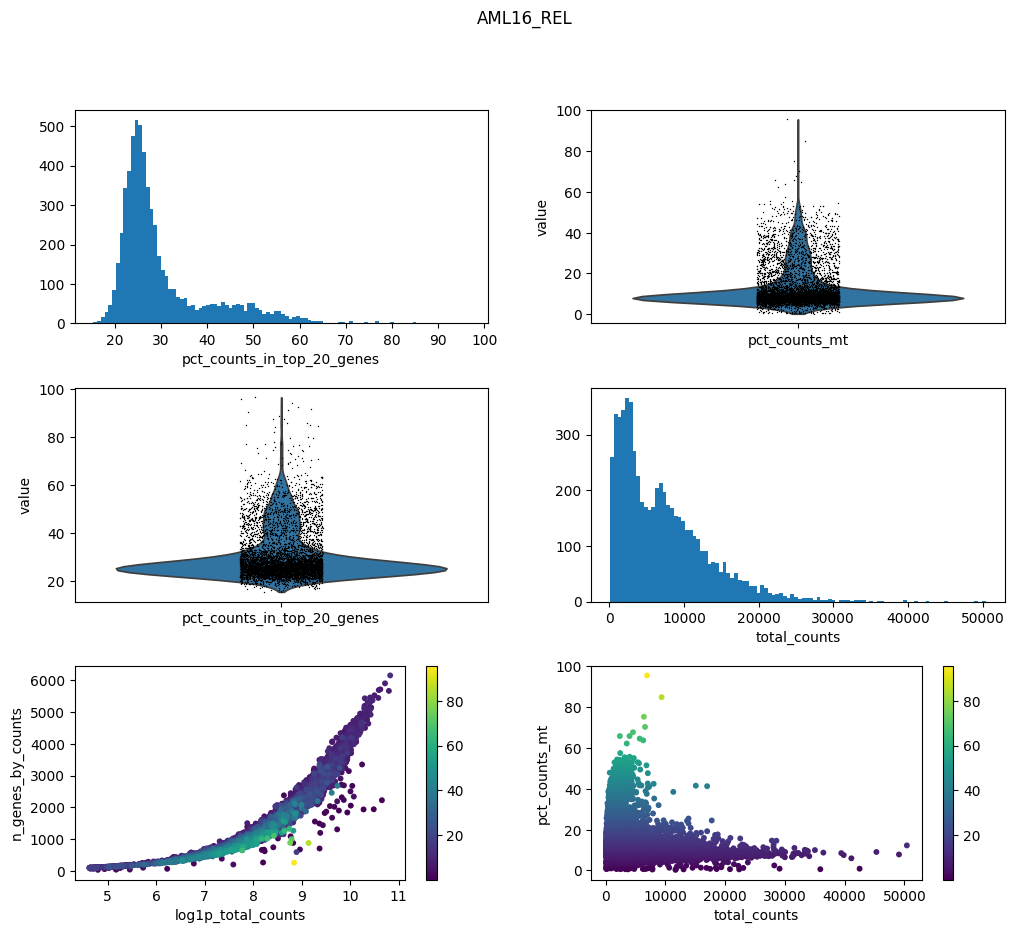

In [22]:
for adata in adatas:
    fig, ax = plt.subplots(3,2, figsize=(12,10))
    fig.suptitle(adata.obs["sample"].iloc[0])
    
    plt.subplots_adjust(wspace=0.25, hspace=0.3)

    plt1 = ax[0, 0].hist(adata.obs["pct_counts_in_top_20_genes"], bins = 100) #ax[row,column]
    ax[0, 0].set_xlabel("pct_counts_in_top_20_genes")

    plt2 = sc.plotting.violin(adata, "pct_counts_mt", ax=ax[0,1], show = False)

    plt3 = sc.plotting.violin(adata, "pct_counts_in_top_20_genes", ax=ax[1,0], show = False)

    plt5 = ax[1,1].hist(adata.obs["total_counts"], bins = 100)
    ax[1,1].set_xlabel("total_counts")

    scatter_plot(adata, ax[2,0], fig, "log1p_total_counts", "n_genes_by_counts", "pct_counts_mt")
    
    scatter_plot(adata, ax[2,1], fig, "total_counts", "pct_counts_mt", "pct_counts_mt")
    #ax[2,1].set_axis_off()
    #plt4 = sc.plotting.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", title = "")
# For a workaround on this plot (there is a problem with plot4's the legend) check https://github.com/scverse/scanpy/issues/1258

We can also use ridge plots for density distributions which are quite usefull wen we have several samples. Might be a good idea to concatenate **observations** dataframes to faciliate plotting per sample:

In [23]:
df1 = pd.concat([adata.obs for adata in adatas])

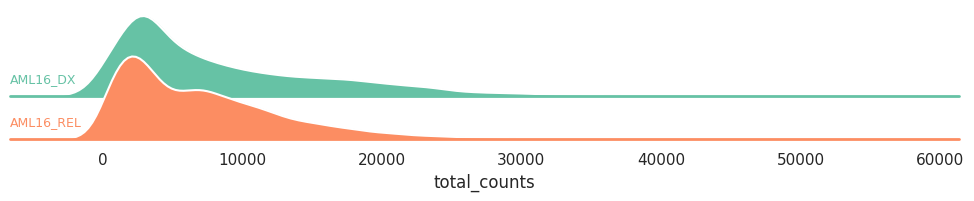

In [24]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})

palette = sns.color_palette("Set2", 12)

g = sns.FacetGrid(df1, palette=palette, row="sample", hue="sample", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="total_counts", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="total_counts", color="white")

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
#g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color=color, fontsize=9,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "sample")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="total_counts")
#g.despine(left=True)
g.despine(bottom=True, left=True)
#plt.suptitle('Total Counts Density', y=0.98)

Or we can plot them in a single graph if there are not many samples:

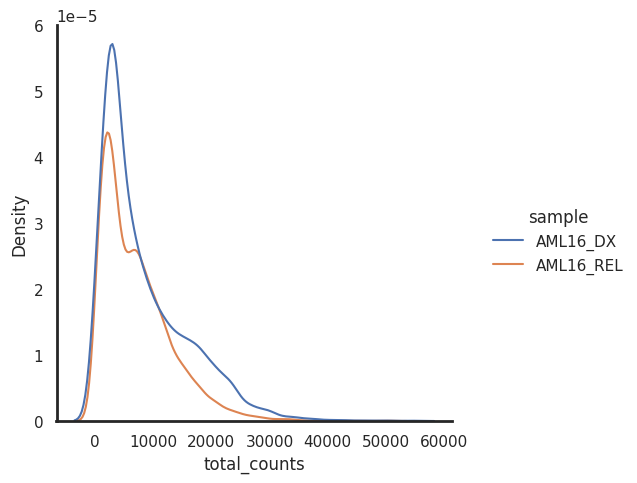

In [25]:
#fig, ax = plt.subplots(figsize=(12,5))
sns.displot(df1, x="total_counts", hue="sample", kind="kde")

We can also group violin plots in a single figure:

<Axes: xlabel='sample', ylabel='total_counts'>

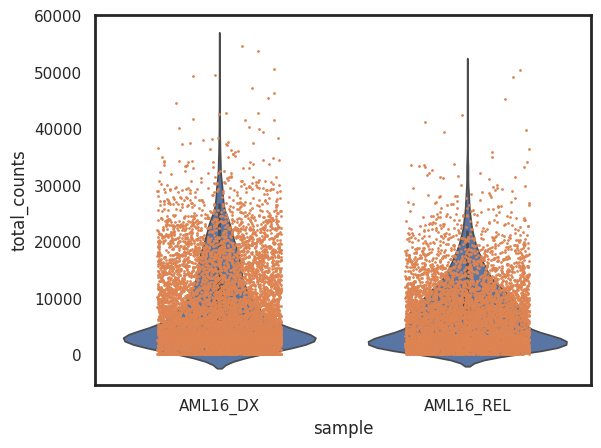

In [26]:
sns.violinplot(x="sample", y="total_counts", data=df1)
#sns.swarmplot(x="sample", y="total_counts", data=df1) Don't use swarmplot as with the amount of data we have will be running forever
sns.stripplot(x="sample", y="total_counts", data=df1, size=2, jitter=0.25)

Most top 20 genes represent between 20% to 30% of the total counts for most barcodes. This is very significant since cells have thousand of genes. In some of the samples there are a high number of cells wit high counts for the top 20 genes with regards to the total. *This might be the result of heterogenous cell populations?*. Why are there still barcodes with low counts? This is probably due to the fact that ``EmptyDrops`` uses the ambient profile to look for signigicant barcodes by comparing it to the RNA content of said barcodes. If a barcode has 0 counts, then it is obvious that its ambient RNA content won't be significant. Either way, it seems that barcodes with counts below ``lower`` were removed (in this case ``lower=100``).

We can also see that most cells have low percentage of mitochondrial counts, but there is a significant amount of cells whose mitochondrial counts represent more than 10% of the total counts. These cells seem to have low total UMI counts, which could mean that they are are low quality cells (with a signigicant content of ambient RNA), and not cells with high energy demands.

The **percentage of RNA UMIs treshold** can vary depending of the cell and tissue type, and high percentages might represent true biological variation (view [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6072887/)). The treshold is highly dependant on the tissue type, and so it should be considered when performing quality filtering.

Let's create a function to remove outliers according to a specific column based on the quality metrics from our **obervations**. We will use the MADs method to remove low quality cells.

In [27]:
import scipy.stats as sts

def is_outlier(adata, metric: str, mads: int):
    column = adata.obs[metric]
    mad = sts.median_abs_deviation(column)
    outlier = (column < np.median(column) - mads*mad) | (column > np.median(column) + mads*mad) # | is an or operator equivalent for array like data or pandas dataframes
    return outlier

Let's indentify outliers based on three common covariates that are symptons of low quality cells: ``total_counts``, ``n_genes_by_counts`` and ``pct_counts_in_top_20_genes``, based on 5 MADs of distance from the median:

In [28]:
for adata in adatas:
    adata.obs["outlier"] = is_outlier(adata, "log1p_total_counts", 5) | is_outlier(adata, "log1p_n_genes_by_counts", 5) | is_outlier(adata, "pct_counts_in_top_20_genes", 5)

In [29]:
sum(adatas[0].obs['outlier'])

888

Why apply the treshold to log-transformed data? A log-transformation is used to improve resolution at small values and to avoid negative thresholds that would be meaningless for a non-negative metric. Furthermore, it is not uncommon for the distribution of library sizes to exhibit a heavy right tail; the log-transformation avoids inflation of the MAD in a manner that might compromise outlier detection on the left tail. (More generally, it makes the distribution seem more normal to justify the 99% rationale mentioned above.) The function will also do the same for the log-transformed number of expressed genes (view [Bioconductor](https://bioconductor.org/books/3.13/OSCA.basic/quality-control.html)).

Let's plot our counts to see how our data changes after filtering. We will create a function for this purpose:

In [30]:
def plot_filt(adata):
    # Plot all values
    fig, ax = plt.subplots(2, 2 , figsize=(12, 10))
    #plt7 = sc.pl.violin(adata, "log1p_total_counts", ax = ax[0], show = False) # show = False is required for some reason
    plot1 = sns.violinplot(y="total_counts", data=adata.obs, ax=ax[0,0])
    plot2 = sns.stripplot(y="total_counts", data=adata.obs.sort_values("outlier"), hue="outlier", jitter=0.2, ax=ax[0,0])
    ax[0,0].set_ylim(0, 200)

    # Plot only values that are not outliers
    plot3 = sns.violinplot(y="total_counts", data=adata.obs[adata.obs["outlier"] == False], ax=ax[0,1])
    plot4 = sns.stripplot(y="total_counts", data=adata.obs[adata.obs["outlier"] == False], jitter=0.2, ax=ax[0,1])
    plot3.set_ylabel("total_counts (filtered)")
    ax[0,1].set_ylim(0, 200)

    # Plot histogram of unfiltered and filtered values
    plot5 = ax[1,0].hist(adata.obs["total_counts"], bins = 100)
    plot6 = ax[1,1].hist(adata.obs[adata.obs["outlier"] == False]["total_counts"], bins = 100)
    
    return fig, ax, plot1, plot2, plot3, plot4, plot5, plot6
    #plt8 = sc.pl.violin(adata[adata.obs["outlier"] == False], "total_counts", 


Notice that in the function we zoomed in the viollin plot, otherwise differences were hard to see. Change ``ax.set_ylim()`` accordingly. And we plot:

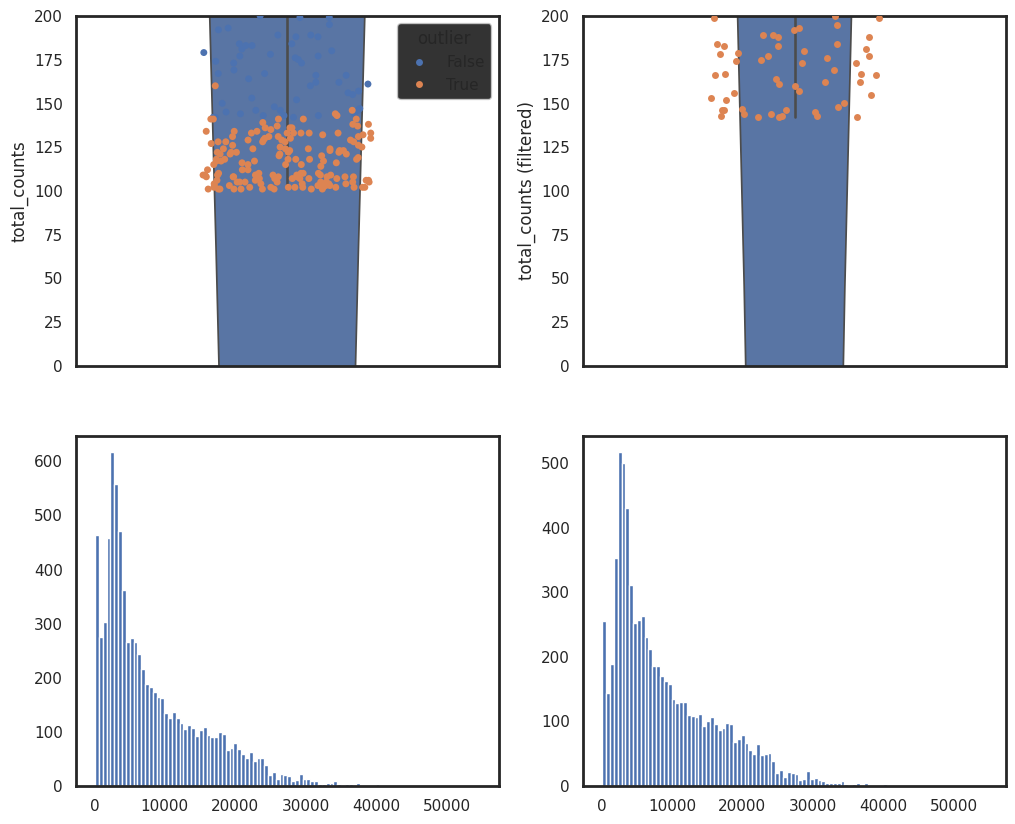

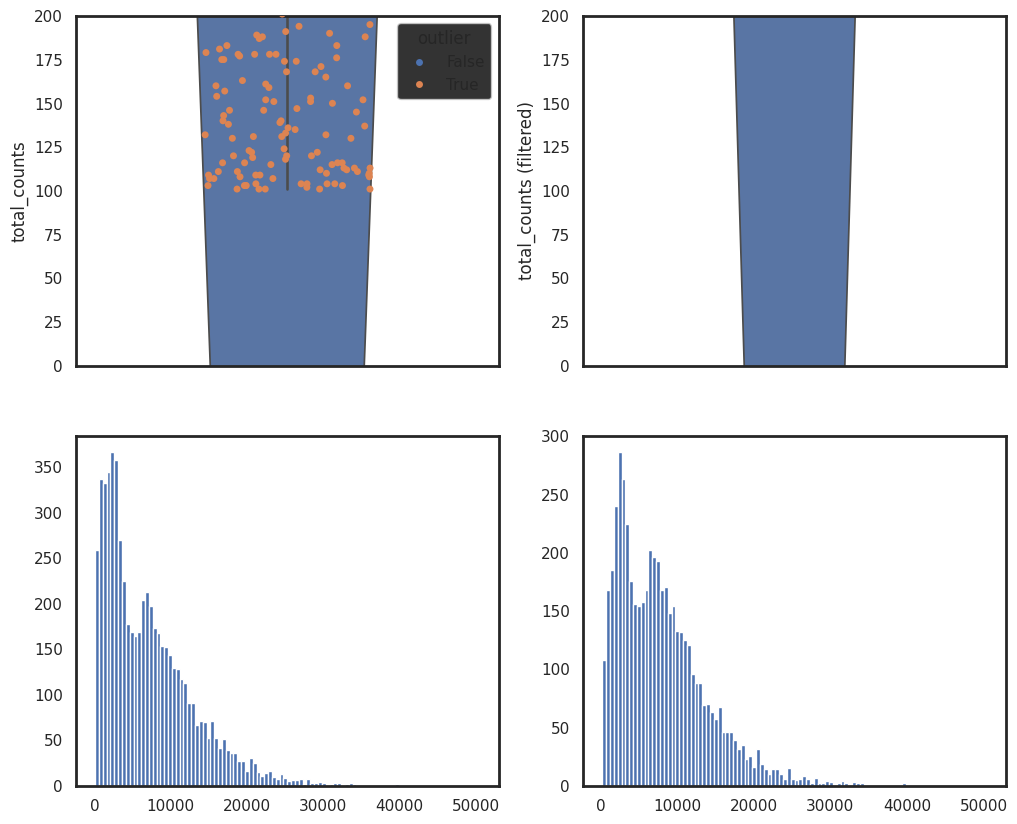

In [31]:
for adata in adatas:
    plot_filt(adata)

Again, instead of doing all of the above, we can use just **two plots**: a density plot and a violin plot:

In [32]:
def violin_dis_plot(df, var1: str, var2: str, var3: str, hue=None):
    fig, axs = plt.subplots(1,3, figsize=(12, 3))
    
    sns.violinplot(x=var2, y=var1, data=df, ax=axs[0])
    sns.stripplot(x=var2, y=var1, data=df.sort_values("outlier"), size=2, jitter=0.25, hue=hue, ax=axs[0])
    sns.kdeplot(df, x=var1, hue=var2, ax=axs[1])
    sns.kdeplot(df, x=var3, hue=var2, ax=axs[2])
    
    for ax in axs:
        ax.legend(fontsize="7", loc ="upper right", facecolor="white")

In [33]:
def violin_dis_plot(df, var1: str, var2: str, var3: str, hue=None):
    fig, ax = plt.subplots(1,3, figsize=(12, 3))

    sns.set(font_scale=0.55)

    sns.violinplot(x=var2, y=var1, data=df, ax=ax[0])
    sns.stripplot(x=var2, y=var1, data=df.sort_values("outlier"), size=2, jitter=0.1, hue=hue, ax=ax[0])
    #ax[0].legend(fontsize="7", loc ="upper right", facecolor="white")
    sns.kdeplot(df, x=var1, hue=var2, ax=ax[1])
    sns.kdeplot(df, x=var3, hue=var2, ax=ax[2])

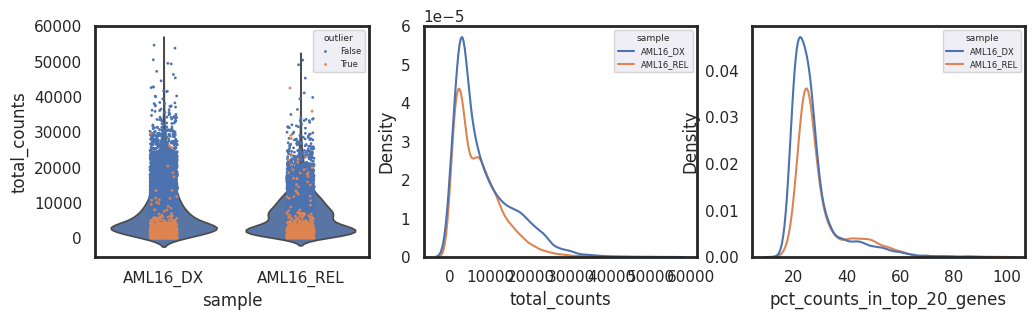

In [34]:
# We added an outlier column to our anndatas, so we need to define the dataframe again
df1 = pd.concat([adata.obs for adata in adatas])

violin_dis_plot(df1, "total_counts", "sample", "pct_counts_in_top_20_genes", "outlier")

We can actually use this function to plot the most important variables.

#### Percentage of mitochondrial counts

Now let's filter low quality barcides based on 3 MADs and cells with a percentage of mt-RNA higher than 8%. Remeber that, as stated before, these values are highly dependant on cell and tissue types, for instance, it will be higher on cells with higher energy demands, such as cardiomiocytes, with up to **30% of the total mRNA belonging to mitochondrial RNA** (view [paper](https://www.cell.com/molecular-therapy-family/methods/fulltext/S2329-0501(18)30066-4?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS2329050118300664%3Fshowall%3Dtrue)).

In [35]:
for adata in adatas:
    mt_outliers = is_outlier(adata, "pct_counts_mt", 3)
    adata.obs["mt_outlier"] = mt_outliers | (adata.obs["pct_counts_mt"] > 8)

Let's plot also the total counts vs percentage of mitochondrial counts now coloring by the ``"mt_outlier"`` field. First create a function:

In [36]:
def scatter_plot_mt(adata, ax):
    plot = sns.scatterplot(x="total_counts", y="pct_counts_mt", data=adata.obs.sort_values("mt_outlier"), ax=ax, hue="mt_outlier", linewidth=0, size=2)
    handles, labels = plot.get_legend_handles_labels() # very ugly fix, look for another solution
    ax.legend(handles[0:2], labels[0:2], fontsize="10")

And plot:

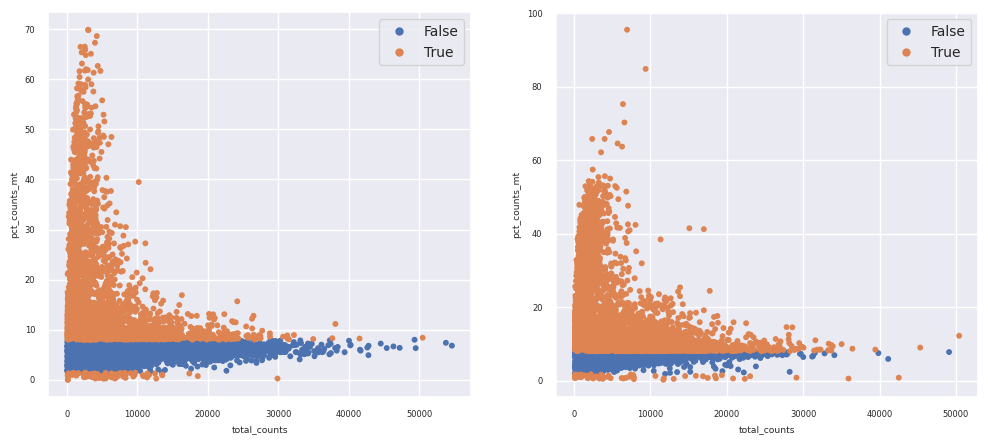

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for adata,ax in zip(adatas, axs):
    scatter_plot_mt(adata, ax)

Looks like a lot of cells were discared. Maybe be less stringent in terms of quality?

Time to subset the data based on the criteria of cell outliers based on the three covariates described above:

In [38]:
adatas = [adata[(~adata.obs["outlier"]) & (~adata.obs["mt_outlier"])] for adata in adatas] # use "~" to call False values, which are the valid values (we don't want ouliers)

In [39]:
sum(adatas[0].obs["mt_outlier"])

0

In [40]:
sum(adatas[0].obs["outlier"])

0

Let's plot again the number of genes by counts vs total counts per barcode and color it by the percentage of mitchondrial counts. Let's create a function first:

In [41]:
def plot_genes_counts(adata):
    fig, ax = plt.subplots(figsize=(12,5))

    # Plot filtered values
    plt9 = sns.scatterplot(x="log1p_total_counts", y="n_genes_by_counts", data=adata.obs.sort_values("pct_counts_mt"), ax=ax, hue="pct_counts_mt", palette="viridis", size=0.1, linewidth=0)
    norm = plt.Normalize(adata.obs["pct_counts_mt"].min(), adata.obs["pct_counts_mt"].max()) # To add color bar
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm) # To add color bar
    sm.set_array([]) # To add color bar
    plt9.get_legend().remove() # To add color bar
    fig.colorbar(sm, ax=ax) # To add color bar

    # Plot unfiltered values
    #plt10 = sns.scatterplot(x="log1p_total_counts", y="n_genes_by_counts", data=adata.obs.sort_values("pct_counts_mt"), ax=ax[1], hue="pct_counts_mt", palette="viridis", size=0.1, linewidth=0)
    #norm = plt.Normalize(adata.obs["pct_counts_mt"].min(), adata.obs["pct_counts_mt"].max()) # To add color bar
    #sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm) # To add color bar
    #sm.set_array([]) # To add color bar
    #plt10.get_legend().remove() # To add color bar
    #fig.colorbar(sm, ax=ax[1]) # To add color bar
#plt9 = sc.pl.scatter(adata_subset, "log1p_total_counts", "n_genes_by_counts", color="pct_counts_mt", title="")
#sc.plotting.scatter(adata, "log1p_total_counts", "n_genes_by_counts", color="pct_counts_mt", title = "")

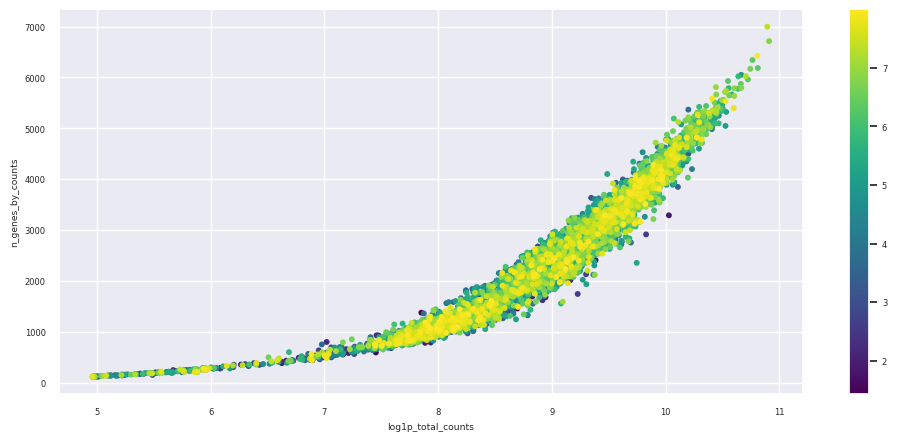

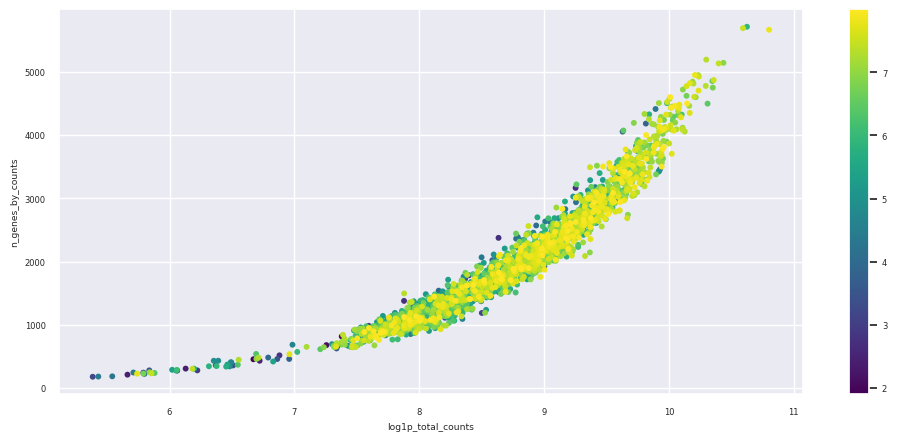

In [42]:
for adata in adatas:
    plot_genes_counts(adata)

And plot again using the ``violin_dis_plot`` function:

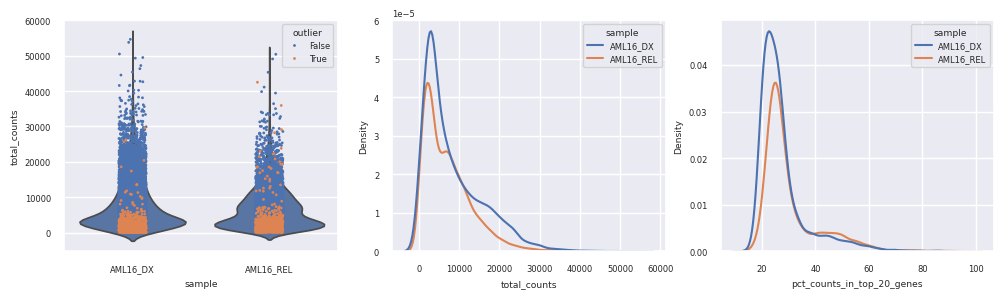

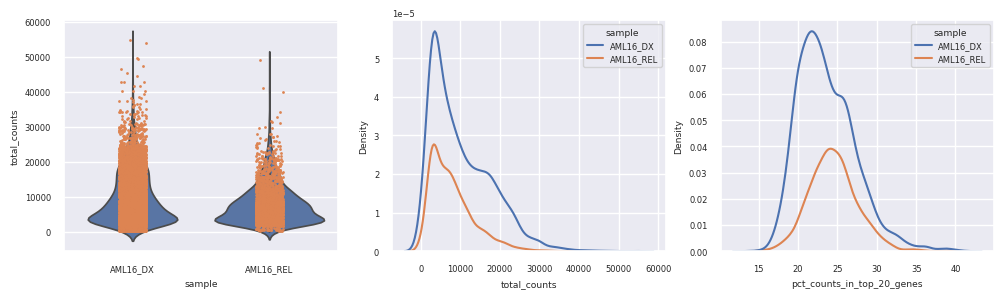

In [43]:
# We can define a new datafram, should not load too much into RAM
df2 = pd.concat([adata.obs for adata in adatas])

violin_dis_plot(df1, "total_counts", "sample", "pct_counts_in_top_20_genes", "outlier") # Unfiltered
violin_dis_plot(df2, "total_counts", "sample", "pct_counts_in_top_20_genes") # Filtered


Now we have the filtered dataset. Note that ``adata.obs[adata.obs["variate"]]`` is equivalent to ``adata[adata.obs.variate].obs``.

### Removal of ambient RNA

It is also important to remove cell free RNA from the droplets, since they can bias the estimation of counts and they are considered as a form of contamination. Methods usually estimate ambient RNA using empty droplets. We will take advantage of interoperability between languages so that we can use tools from R and Python, and use the most appropiate libraries both platforms offer. For this, we are going to use again the ``rpy2``.

Before using ``SoupX`` for the removal of ambient RNA, it is necessary to first cluster cells. Why log transform the data? It seems that single cell methods for DE do not use GLM for fitting the data and estimating the coefficients (check [this](https://github.com/scverse/scanpy/issues/1364)). We will do a quick normalization, data transformation and clustering in order to estimate the ambient RNA, and explain later in more detail. We will create a new list from the ``adatas`` list since we will perfrom clustering  and normalization again. Let's prepare our data:

In [44]:
adatas_amb = [adata.copy() for adata in adatas]
for adata in adatas_amb:
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

We will perform a PCA for dimensionality reduction followed by clustering using the Leiden algorithm. We will add a new column to our ``obs`` with the cluster group for each cell called ``soupx_groups``:

In [45]:
#!pip3 install igraph
#!pip3 install leidenalg
for adata in adatas_amb:
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata, key_added="soupx_groups")

/tmp/ipykernel_403/1962490550.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="soupx_groups")


Let's check the clusters and save the information in a new variable, which we will use later as input for ``SoupX``:

In [46]:
soupx_groups = [adata.obs["soupx_groups"] for adata in adatas_amb]

We can add the groups to our original adata, which will come in handy later on:

In [47]:
for adata, gr in zip(adatas, soupx_groups):
    adata.obs["soupx_groups"] = gr

/tmp/ipykernel_403/272882583.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["soupx_groups"] = gr
/tmp/ipykernel_403/272882583.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["soupx_groups"] = gr


We can now remove our normalized and transformed ``adata_subset2`` to free memory:

In [49]:
del adatas_amb

In [50]:
adatas

[AnnData object with n_obs × n_vars = 5358 × 33538
     obs: 'sample', 'patient', 'dx', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'soupx_groups'
     var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
 AnnData object with n_obs × n_vars = 2127 × 33538
     obs: 'sample', 'patient', 'dx', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'm

``SoupX`` requires raw data and filtered data with all droplets coatining cells. We need to prepare our filtered data to parse it to R. We will extract the sprase matrix, column and row names of each adata and store them inside a list.

Now let's run ``SpoupX``:

In [54]:
%%R

suppressMessages(library(SoupX))
suppressMessages(library(Matrix))

make_soup = function(raw_files, genes, barcodes, filt_data, soupx_groups){

    # First load unfiltered data
    # Read .mtx file
    tod = readMM(raw_files[3])

    # Read .tsv files
    raw_barcodes = read.table(raw_files[1], sep = "\t", header = FALSE)
    # Add the appropiate rownames and column names to the sparse matrix
    rownames(tod) = genes
    colnames(tod) = raw_barcodes[,1]

    # Prepare filtered data
    toc = as(filt_data, "sparseMatrix")
    rownames(toc) = genes
    colnames(toc) = barcodes

    # Run SoupX
    sc = SoupChannel(tod, toc, calcSoupProfile = FALSE)
    print("Calculate soup profile")
    soupProf = data.frame(row.names = rownames(toc), est = rowSums(toc)/sum(toc), counts = rowSums(toc))
    sc = setSoupProfile(sc, soupProf)
    print("Set clusters")
    sc = setClusters(sc, soupx_groups)
    print("Estimate contamination fraction")
    sc  = autoEstCont(sc, doPlot=FALSE)
    print("Infer corrected table of counts and rount to integer")
    out = adjustCounts(sc, roundToInt = TRUE)

    return(out)
}


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

If we want to use **R** and python in the same cell, we will have to use the ``%R`` magic oneliner. The output ``-o out`` will be a **sparse matrix** with the modified **ambient filtered counts**:

In [55]:
for adata, raw_files in zip(adatas, trial):
    soupx_groups = adata.obs["soupx_groups"]
    filt_data = adata.X.T
    barcodes = adata.obs_names
    genes = adata.var_names
    
    %R -i raw_files -i genes -i barcodes -i filt_data -i soupx_groups -o out out = make_soup(raw_files, genes, barcodes, filt_data, soupx_groups)
    
    adata.layers["raw_counts"] = adata.X # We wamt to keep the pre ambient filtered counts
    adata.layers["soupx_counts"] = out.T # Remember that most R packages need a transposed matrix with repect to scanpy
    adata.X = adata.layers["soupx_counts"] # We want our filtered counts to be the default counts

[1] "Calculate soup profile"
[1] "Set clusters"
[1] "Estimate contamination fraction"
[1] "Infer corrected table of counts and rount to integer"


976 genes passed tf-idf cut-off and 106 soup quantile filter.  Taking the top 100.
Using 1031 independent estimates of rho.
Estimated global rho of 0.01
Expanding counts from 18 clusters to 5358 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


[1] "Calculate soup profile"
[1] "Set clusters"
[1] "Estimate contamination fraction"
[1] "Infer corrected table of counts and rount to integer"


417 genes passed tf-idf cut-off and 94 soup quantile filter.  Taking the top 94.
Using 761 independent estimates of rho.
Estimated global rho of 0.02
Expanding counts from 14 clusters to 2127 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


This will output an sparse matrix